In [ ]:
!pip install torchxrayvision
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.0 MB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ff7ba5342e73fe007574b0630e6adffffa7da51e91604039d8b89db210c9902e
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[147]:

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import pandas as pd
import random
from shutil import copyfile
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import re
import albumentations as albu
# from albumentations.pytorch import ToTensor
# from catalyst.data import Augmentor
import torchxrayvision as xrv
import warnings
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


import torch
import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from sklearn.metrics import roc_auc_score
import re
import albumentations as albu
# from albumentations.pytorch import ToTensor
# from catalyst.data import Augmentor
from skimage.io import imread, imsave
import skimage

torch.cuda.empty_cache()

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224), scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [ ]:
batchsize = 10


def read_txt(txt_path):
    # print(txt_path, type(txt_path))
    f = open(txt_path, 'r')
    lines = f.readlines()
    # with open(txt_path) as f:
    #     lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data


class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID, txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir, self.classes[c], item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample

# gan link tap du lieu vao linkfile nay
# linkfile data: https://drive.google.com/drive/folders/1DJTUqXGKVgQbx6dmpzTmBiTAv4NLptpC?usp=sharing

linkfile = '/content/drive/MyDrive/Colab Notebooks/Scan_CT_image_COVID19'

if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='{}/Images-processed'.format(linkfile),
                              txt_COVID='{}/Data-split/COVID/trainCT_COVID.txt'.format(linkfile),
                              txt_NonCOVID='{}/Data-split/NonCOVID/trainCT_NonCOVID.txt'.format(linkfile),
                              transform=train_transformer)
    valset = CovidCTDataset(root_dir='{}/Images-processed'.format(linkfile),
                            txt_COVID='{}/Data-split/COVID/valCT_COVID.txt'.format(linkfile),
                            txt_NonCOVID='{}/Data-split/NonCOVID/valCT_NonCOVID.txt'.format(linkfile),
                            transform=val_transformer)
    testset = CovidCTDataset(root_dir='{}/Images-processed'.format(linkfile),
                             txt_COVID='{}/Data-split/COVID/testCT_COVID.txt'.format(linkfile),
                             txt_NonCOVID='{}/Data-split/NonCOVID/testCT_NonCOVID.txt'.format(linkfile),
                             transform=val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)


425
118
203


In [ ]:
alpha = None
device = 'cuda'
loss_train_dict = {}
acc_train_dict = {}

def train(optimizer, epoch):
    model.train()

    train_loss = 0
    train_correct = 0

    for batch_index, batch_samples in enumerate(train_loader):

        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        #        data = data[:, 0, :, :]
        #        data = data[:, None, :, :]
        #         data, targets_a, targets_b, lam = mixup_data(data, target.long(), alpha, use_cuda=True)

        optimizer.zero_grad()
        output = model(data)

        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        #         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)
        train_loss += criteria(output, target.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()

        # Display progress and write to tensorboard
        #if batch_index % bs == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
        #        epoch, batch_index, len(train_loader),
        #        100.0 * batch_index / len(train_loader), loss.item() / bs))

    print('\nEpoch {}: Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch, 
        train_loss / len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    
    loss_train_dict[epoch] = train_loss.item() / len(train_loader.dataset)
    acc_train_dict[epoch] = 100.0 * train_correct / len(train_loader.dataset)

    f = open('/content/model_result/{}.txt'.format(modelname), 'a+')
    f.write('\nTrain epoch: {}\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, train_loss / len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    f.write('\n')
    f.close()


In [ ]:
loss_val_dict = {}
acc_val_dict = {}

def val(epoch):
    model.eval()
    val_loss = 0
    correct = 0
    results = []

    TP = 0
    TN = 0
    FN = 0
    FP = 0

    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []

        predlist = []
        scorelist = []
        targetlist = []
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            #            data = data[:, 0, :, :]
            #            data = data[:, None, :, :]
            output = model(data)

            val_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            #             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()

            #             print(output[:,1].cpu().numpy())
            #             print((output[:,1]+output[:,0]).cpu().numpy())
            #             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu = target.long().cpu().numpy()
            predlist = np.append(predlist, pred.cpu().numpy())
            scorelist = np.append(scorelist, score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, targetcpu)

    loss_val_dict[epoch] = val_loss.item() / len(val_loader.dataset)
    acc_val_dict[epoch] = 100.0 * correct / len(val_loader.dataset)
    print('Val set: Loss: {:.4f}, Accuracy: {:.2f}%)\n'.format(
        val_loss / len(val_loader.dataset), 100.0 * correct / len(val_loader.dataset)))

    return targetlist, scorelist, predlist


In [ ]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    results = []

    TP = 0
    TN = 0
    FN = 0
    FP = 0

    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []

        predlist = []
        scorelist = []
        targetlist = []
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            #            data = data[:, 0, :, :]
            #            data = data[:, None, :, :]
            #             print(target)
            output = model(data)

            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            #             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            #             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
            #             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
            # #             # FN    predict 0 label 1
            #             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
            # #             # FP    predict 1 label 0
            #             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
            #             print(TP,TN,FN,FP)

            #             print(output[:,1].cpu().numpy())
            #             print((output[:,1]+output[:,0]).cpu().numpy())
            #             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu = target.long().cpu().numpy()
            predlist = np.append(predlist, pred.cpu().numpy())
            scorelist = np.append(scorelist, score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, targetcpu)

    return targetlist, scorelist, predlist


In [ ]:
class DenseNetModel(nn.Module):

    def __init__(self):
        """
        Pass in parsed HyperOptArgumentParser to the model
        :param hparams:
        """
        super(DenseNetModel, self).__init__()

        self.dense_net = xrv.models.DenseNet(num_classes=2)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        logits = self.dense_net(x)
        return logits


model = DenseNetModel().cuda()
modelname = 'DenseNet_medical'


In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()  # b, 3, 32, 32
        layer1 = torch.nn.Sequential()
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))

        # b, 32, 32, 32
        layer1.add_module('relu1', torch.nn.ReLU(True))
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))  # b, 32, 16, 16 //池化为16*16
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(401408, 2))
        self.layer4 = layer4

    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)


model = SimpleCNN().cuda()
modelname = 'SimpleCNN'

In [ ]:
'''
### ResNet18
import torchvision.models as models

model = models.resnet18(pretrained=True).cuda()
modelname = 'ResNet18'

# In[106]:


### Dense121
import torchvision.models as models

model = models.densenet121(pretrained=True).cuda()
modelname = 'Dense121'

# In[109]:
'''

### Dense169
import torchvision.models as models

model = models.densenet169(pretrained=True).cuda()
modelname = 'Dense169'
'''
# In[100]:


### ResNet50
import torchvision.models as models

model = models.resnet50(pretrained=True).cuda()
modelname = 'ResNet50'

# In[114]:


### VGGNet
import torchvision.models as models

model = models.vgg16(pretrained=True)
model = model.cuda()
modelname = 'vgg16'

# In[139]:


### efficientNet
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
model = model.cuda()
modelname = 'efficientNet_b0'
'''

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

"\n# In[100]:\n\n\n### ResNet50\nimport torchvision.models as models\n\nmodel = models.resnet50(pretrained=True).cuda()\nmodelname = 'ResNet50'\n\n# In[114]:\n\n\n### VGGNet\nimport torchvision.models as models\n\nmodel = models.vgg16(pretrained=True)\nmodel = model.cuda()\nmodelname = 'vgg16'\n\n# In[139]:\n\n\n### efficientNet\nfrom efficientnet_pytorch import EfficientNet\n\nmodel = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)\nmodel = model.cuda()\nmodelname = 'efficientNet_b0'\n"

In [ ]:
if not os.path.exists('model_result'):
    os.makedirs('model_result')

if not os.path.exists('model_backup'):
    os.makedirs('model_backup')


Epoch 1: Train set: Average loss: 0.4401, Accuracy: 188/425 (44%)
Val set: Loss: 0.3855, Accuracy: 63.56%)


Epoch 2: Train set: Average loss: 0.0893, Accuracy: 356/425 (84%)
Val set: Loss: 0.1588, Accuracy: 70.34%)


Epoch 3: Train set: Average loss: 0.0506, Accuracy: 370/425 (87%)
Val set: Loss: 0.0895, Accuracy: 79.66%)


Epoch 4: Train set: Average loss: 0.0228, Accuracy: 394/425 (93%)
Val set: Loss: 0.0852, Accuracy: 75.42%)


Epoch 5: Train set: Average loss: 0.0215, Accuracy: 395/425 (93%)
Val set: Loss: 0.0939, Accuracy: 82.20%)


Epoch 6: Train set: Average loss: 0.0131, Accuracy: 404/425 (95%)
Val set: Loss: 0.0765, Accuracy: 77.12%)


Epoch 7: Train set: Average loss: 0.0132, Accuracy: 402/425 (95%)
Val set: Loss: 0.1019, Accuracy: 77.97%)


Epoch 8: Train set: Average loss: 0.0096, Accuracy: 410/425 (96%)
Val set: Loss: 0.1149, Accuracy: 77.12%)


Epoch 9: Train set: Average loss: 0.0152, Accuracy: 407/425 (96%)
Val set: Loss: 0.1117, Accuracy: 78.81%)


Epoch 10: Train se

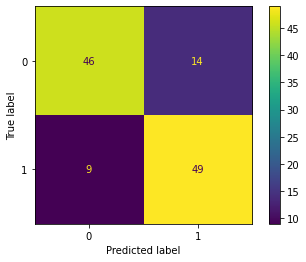

TP+FP 58
precision 0.7241379310344828
recall 0.7241379310344828
F1 0.7241379310344829
acc 0.7288135593220338
AUCp 0.728735632183908
AUC 0.885057471264368

The epoch is 10, average recall: 0.7241, average precision: 0.7241,average F1: 0.7241, average accuracy: 0.7288, average AUC: 0.8851

Epoch 11: Train set: Average loss: 0.0195, Accuracy: 400/425 (94%)
Val set: Loss: 0.0537, Accuracy: 86.44%)


Epoch 12: Train set: Average loss: 0.0089, Accuracy: 412/425 (97%)
Val set: Loss: 0.0737, Accuracy: 81.36%)


Epoch 13: Train set: Average loss: 0.0115, Accuracy: 410/425 (96%)
Val set: Loss: 0.0839, Accuracy: 79.66%)


Epoch 14: Train set: Average loss: 0.0118, Accuracy: 404/425 (95%)
Val set: Loss: 0.0793, Accuracy: 78.81%)


Epoch 15: Train set: Average loss: 0.0095, Accuracy: 413/425 (97%)
Val set: Loss: 0.0971, Accuracy: 80.51%)


Epoch 16: Train set: Average loss: 0.0072, Accuracy: 414/425 (97%)
Val set: Loss: 0.1006, Accuracy: 77.12%)


Epoch 17: Train set: Average loss: 0.0037, Accuracy

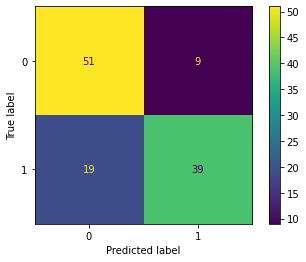

TP+FP 51
precision 0.8627450980392157
recall 0.7586206896551724
F1 0.8073394495412843
acc 0.8220338983050848
AUCp 0.8209770114942528
AUC 0.9054597701149425

The epoch is 20, average recall: 0.7586, average precision: 0.8627,average F1: 0.8073, average accuracy: 0.8220, average AUC: 0.9055


In [ ]:
# train
bs = 10
votenum = 10

import warnings
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# scheduler = StepLR(optimizer, step_size=1)

total_epoch = 20

loss_train_dict.clear()
acc_train_dict.clear()
loss_val_dict.clear()
acc_val_dict.clear()

for epoch in range(1, total_epoch + 1):
    train(optimizer, epoch)
    targetlist, scorelist, predlist = val(epoch)
    #print('target', targetlist)
    #print('score', scorelist)
    #print('predict', predlist)
    vote_pred = vote_pred + predlist
    vote_score = vote_score + scorelist

    if epoch % votenum == 0:
        cm_pred = confusion_matrix(targetlist, predlist)
        Matrix = ConfusionMatrixDisplay(cm_pred)

        Matrix.plot()

        plt.show()
        # major vote
        vote_pred[vote_pred <= (votenum / 2)] = 0
        vote_pred[vote_pred > (votenum / 2)] = 1
        vote_score = vote_score / votenum

        #print('vote_pred', vote_pred)
        #print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()

        print('TP+FP', TP + FP)
        p = TP / (TP + FP)
        print('precision', p)

        r = TP / (TP + FN)
        print('recall', r)

        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)

        print('F1', F1)
        print('acc', acc)

        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)

        #         if epoch == total_epoch:
        torch.save(model.state_dict(), "/content/model_backup/{}.pt".format(modelname))

        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print(
            '\nThe epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
                epoch, r, p, F1, acc, AUC))
        
        f = open('/content/model_result/{}.txt'.format(modelname), 'a+')
        f.write(
            '\nThe epoch is {}, average recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
                epoch, r, p, F1, acc, AUC))
        f.close()

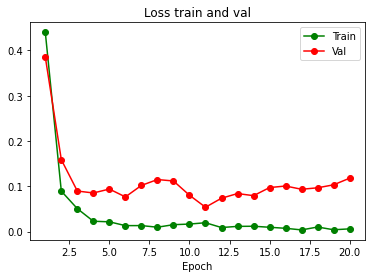

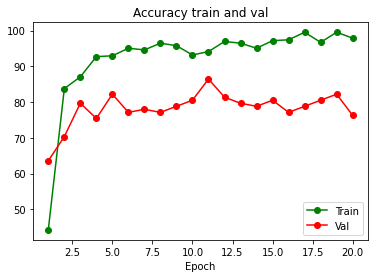

In [ ]:
epoch_list = []
loss_train_list = []
acc_train_list = []
loss_val_list = []
acc_val_list = []

for epoch in range(1, total_epoch + 1):
    epoch_list.append(epoch)
    loss_train_list.append(loss_train_dict[epoch])
    acc_train_list.append(acc_train_dict[epoch])
    loss_val_list.append(loss_val_dict[epoch])
    acc_val_list.append(acc_val_dict[epoch])


plt.plot(epoch_list,loss_train_list,'go-',label='Train')
plt.plot(epoch_list,loss_val_list,'ro-',label='Val')
plt.title('Loss train and val')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()


plt.plot(epoch_list,acc_train_list,'go-',label='Train')
plt.plot(epoch_list,acc_val_list,'ro-',label='Val')
plt.title('Accuracy train and val')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

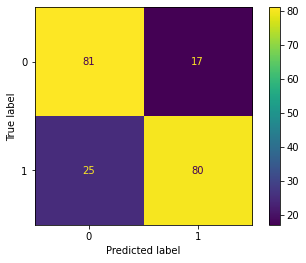

Precision:  0.8247422680412371
Recall:  0.7619047619047619
F1:  0.792079207920792
Accuracy:  0.7931034482758621
AUC:  0.8844509232264335


In [ ]:
# test
bs = 10

warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scheduler = StepLR(optimizer, step_size=1)


targetlist, scorelist, predlist = test(epoch)

cm_pred = confusion_matrix(targetlist, predlist)
Matrix = ConfusionMatrixDisplay(cm_pred)

Matrix.plot()

plt.show()
#     print('target',targetlist)
#     print('score',scorelist)
#     print('predict',predlist)
vote_pred = vote_pred + predlist
vote_score = vote_score + scorelist

TP = ((predlist == 1) & (targetlist == 1)).sum()
TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

p = TP / (TP + FP)
print('Precision: ', p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('Recall: ', r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1: ', F1)
print('Accuracy: ', acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC: ', AUC)

f = open(f'model_result/test_{modelname}.txt', 'a+')
f.write('\nAverage recall: {:.4f}, average precision: {:.4f},average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
    r, p, F1, acc, AUC))
f.close()
